# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import cv2
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pickled data
import pickle

training_file = "./dataset/train.p"
validation_file= "./dataset/valid.p"
testing_file = "./dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

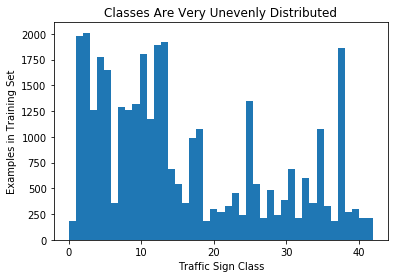

In [4]:
plt.hist(y_train, n_classes, histtype='bar')
plt.title("Classes Are Very Unevenly Distributed")
plt.xlabel("Traffic Sign Class")
plt.ylabel("Examples in Training Set")
plt.show()

In [5]:
# load human readable class labels from csv and store in a dict
import csv
class_labels = {}
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    class_labels = {key: val for key, val in reader}

In [6]:
def visualize_class(X_data, y_labels=[], cmap=None,
                    rows=1, cols=12, maxtitlelen=18, figsize=(15,1)):
    """
    Convenience method to visualize sets of images. If a set of corresponding
    class labels is passed, they will be printed along with the image.
    """
    has_labels = len(y_labels) > 0
    assert not has_labels or len(X_data) == len(y_labels)

    plt.figure(figsize=figsize)
    for i, img in enumerate(X_data):
        plt.subplot(rows, cols, i+1, xticks=[], yticks=[])
        plt.imshow(img, interpolation="nearest", cmap=cmap)
        if has_labels:
            y_val = y_labels[i]
            y_label = class_labels[str(y_val)][:maxtitlelen]
            plt.title("{}: {}".format(y_val, y_label), loc="left")
    plt.show()

LABEL: 0 "Speed limit (20km/h)"
COUNT: 180


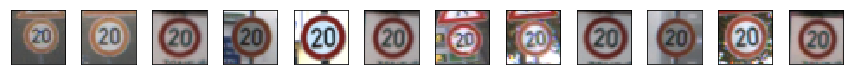

LABEL: 1 "Speed limit (30km/h)"
COUNT: 1980


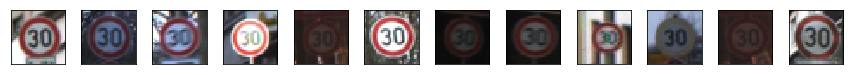

LABEL: 2 "Speed limit (50km/h)"
COUNT: 2010


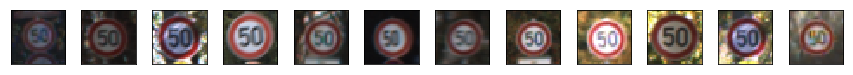

LABEL: 3 "Speed limit (60km/h)"
COUNT: 1260


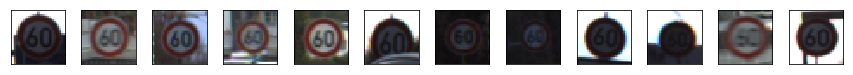

LABEL: 4 "Speed limit (70km/h)"
COUNT: 1770


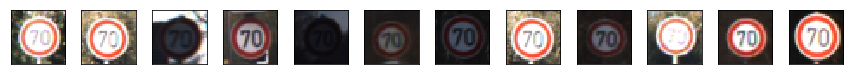

LABEL: 5 "Speed limit (80km/h)"
COUNT: 1650


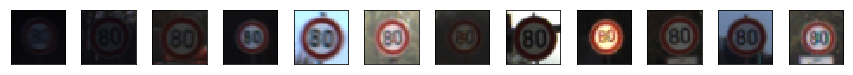

LABEL: 6 "End of speed limit (80km/h)"
COUNT: 360


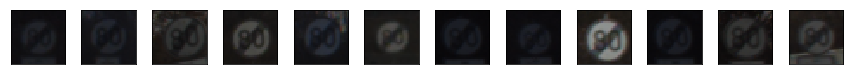

LABEL: 7 "Speed limit (100km/h)"
COUNT: 1290


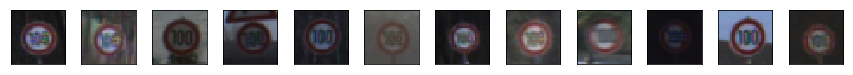

LABEL: 8 "Speed limit (120km/h)"
COUNT: 1260


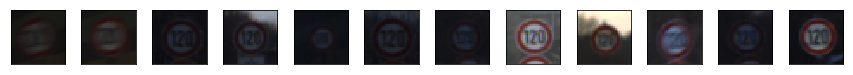

LABEL: 9 "No passing"
COUNT: 1320


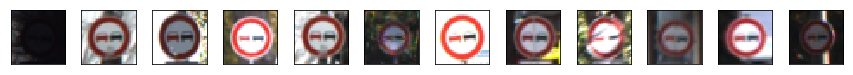

LABEL: 10 "No passing for vehicles over 3.5 metric tons"
COUNT: 1800


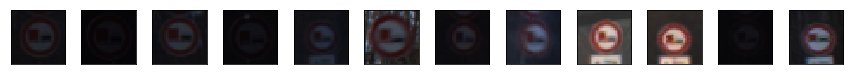

LABEL: 11 "Right-of-way at the next intersection"
COUNT: 1170


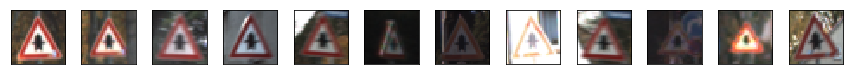

LABEL: 12 "Priority road"
COUNT: 1890


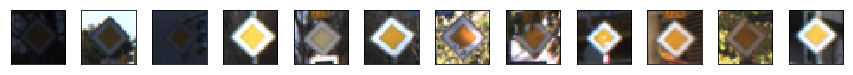

LABEL: 13 "Yield"
COUNT: 1920


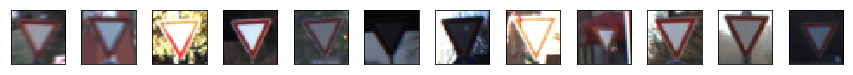

LABEL: 14 "Stop"
COUNT: 690


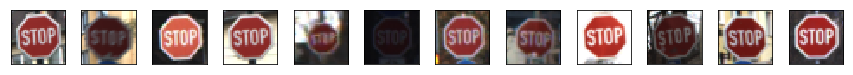

LABEL: 15 "No vehicles"
COUNT: 540


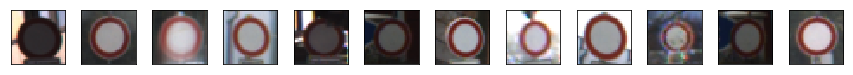

LABEL: 16 "Vehicles over 3.5 metric tons prohibited"
COUNT: 360


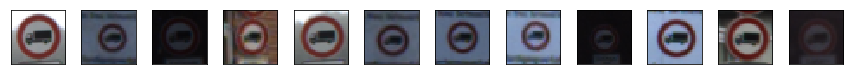

LABEL: 17 "No entry"
COUNT: 990


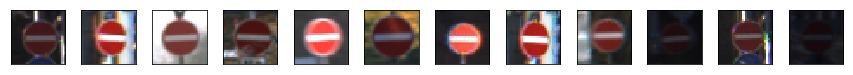

LABEL: 18 "General caution"
COUNT: 1080


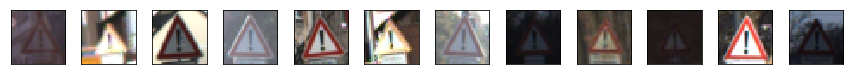

LABEL: 19 "Dangerous curve to the left"
COUNT: 180


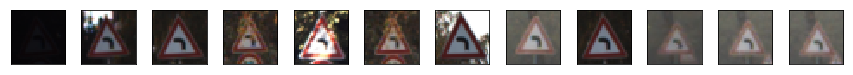

LABEL: 20 "Dangerous curve to the right"
COUNT: 300


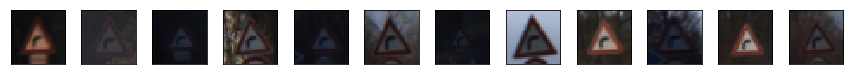

LABEL: 21 "Double curve"
COUNT: 270


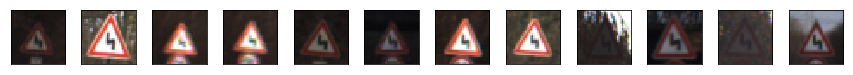

LABEL: 22 "Bumpy road"
COUNT: 330


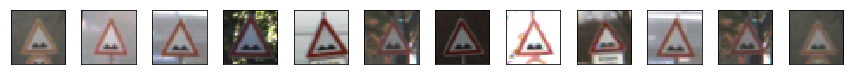

LABEL: 23 "Slippery road"
COUNT: 450


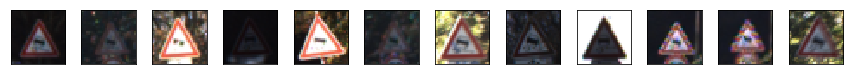

LABEL: 24 "Road narrows on the right"
COUNT: 240


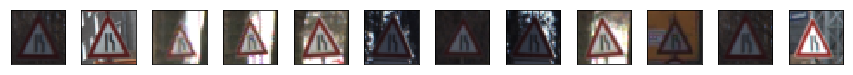

LABEL: 25 "Road work"
COUNT: 1350


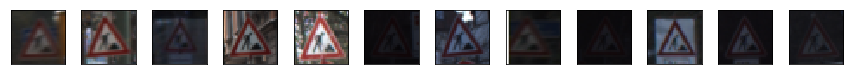

LABEL: 26 "Traffic signals"
COUNT: 540


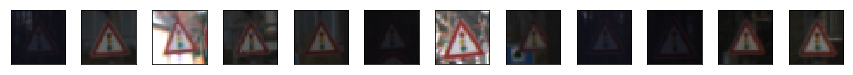

LABEL: 27 "Pedestrians"
COUNT: 210


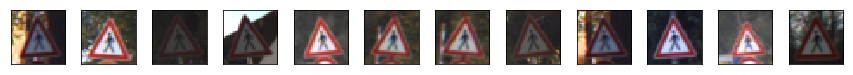

LABEL: 28 "Children crossing"
COUNT: 480


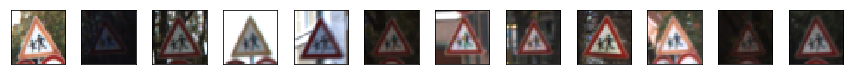

LABEL: 29 "Bicycles crossing"
COUNT: 240


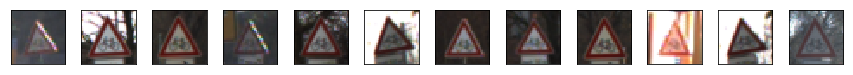

LABEL: 30 "Beware of ice/snow"
COUNT: 390


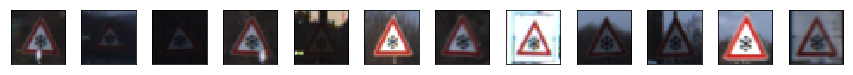

LABEL: 31 "Wild animals crossing"
COUNT: 690


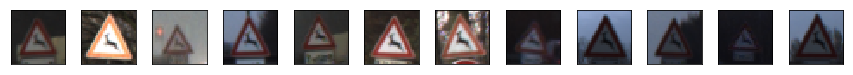

LABEL: 32 "End of all speed and passing limits"
COUNT: 210


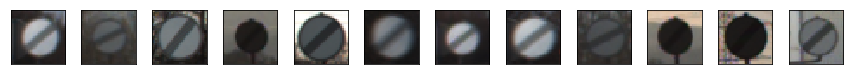

LABEL: 33 "Turn right ahead"
COUNT: 599


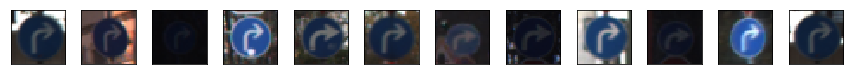

LABEL: 34 "Turn left ahead"
COUNT: 360


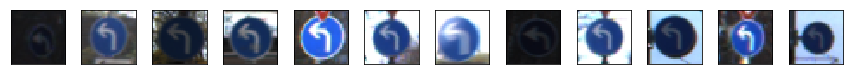

LABEL: 35 "Ahead only"
COUNT: 1080


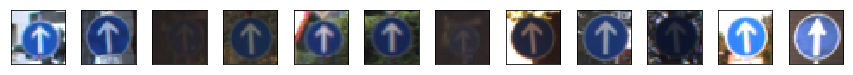

LABEL: 36 "Go straight or right"
COUNT: 330


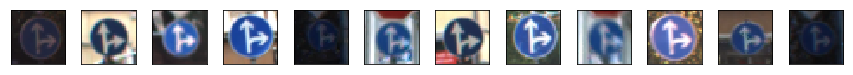

LABEL: 37 "Go straight or left"
COUNT: 180


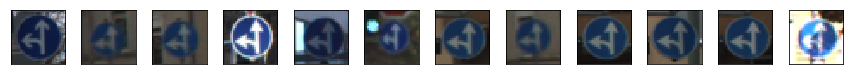

LABEL: 38 "Keep right"
COUNT: 1860


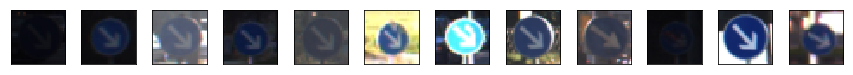

LABEL: 39 "Keep left"
COUNT: 270


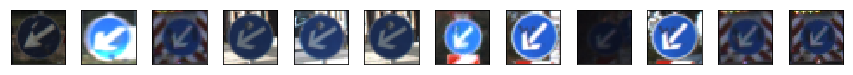

LABEL: 40 "Roundabout mandatory"
COUNT: 300


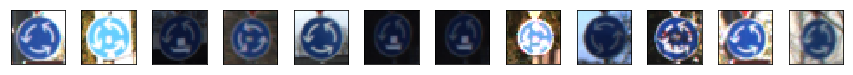

LABEL: 41 "End of no passing"
COUNT: 210


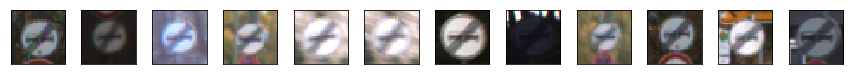

LABEL: 42 "End of no passing by vehicles over 3.5 metric tons"
COUNT: 210


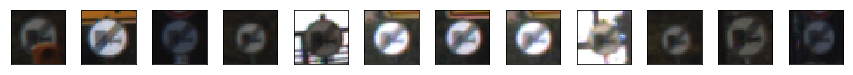

In [7]:
for cls in range(n_classes):
    print("=" * 95)
    print('LABEL: {} "{}"'.format(cls, class_labels[str(cls)]))
    print('COUNT: {}'.format(y_train[y_train==cls].shape[0]))
    class_xs = X_train[y_train==cls]
    visualize_class(class_xs[np.random.choice(class_xs.shape[0], size=12)])

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [8]:
def preprocess(images):
    """
    1. Convert each image to grayscale and equalize histogram
    2. Normalize image values and set the mean to zero
    """
    out = np.empty(images.shape[:3], dtype=np.float32)
    for idx in range(out.shape[0]):
        out[idx] = cv2.equalizeHist(cv2.cvtColor(images[idx], cv2.COLOR_RGB2GRAY))
        out[idx] = cv2.normalize(out[idx], out[idx], alpha=-0.5, beta=0.5,
                                 norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return out.reshape(out.shape + (1,))

In [9]:
# preprocess data and copy y_labels to avoid shuffling original data during training
X_train_process, y_train_process = preprocess(X_train), np.copy(y_train)
X_valid_process, y_valid_process = preprocess(X_valid), np.copy(y_valid)
X_test_process, y_test_process = preprocess(X_test), np.copy(y_test)

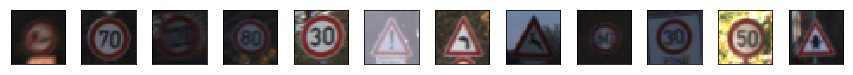

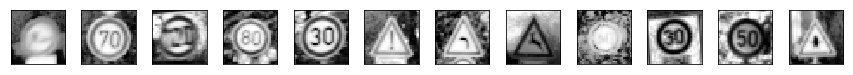

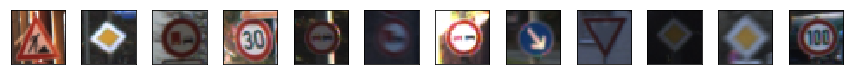

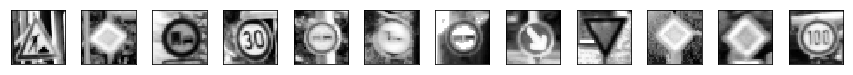

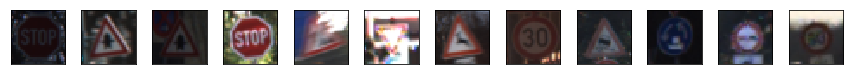

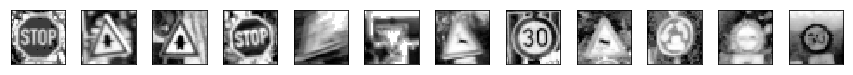

In [10]:
for index in range(3):
    rand_indices = np.random.choice(X_train.shape[0], size=12)
    subset_unprocessed = X_train[rand_indices]
    subset_processed = X_train_process[rand_indices]
    visualize_class(subset_unprocessed)
    visualize_class(subset_processed.reshape(subset_processed.shape[:3]), cmap="gray")

### Model Architecture

In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 101
BATCH_SIZE = 256
LEARN_RATE = 0.001
SAVE_FILE = "./dataset/model.ckpt"

# Store layers weight & bias
weight_var = lambda w_shape: tf.Variable(tf.truncated_normal(w_shape, mean=0, stddev=0.1), name="weights")
bias_var = lambda n_vars: tf.Variable(tf.zeros(n_vars), name="biases")

def conv2d(layer, W, b, strides=1):
    out = tf.nn.conv2d(layer, W, strides=(1,strides,strides,1), padding="SAME")
    out = tf.nn.bias_add(out, b)
    return tf.nn.relu(out, name="relu")

def pool(layer, k=2):
    return tf.nn.max_pool(layer, ksize=(1,k,k,1), strides=(1,k,k,1), padding="SAME", name="pool")

def fully_connected(layer, W, b, activate=True):
    out = tf.add(tf.matmul(layer, W), b)
    if activate:
        out = tf.nn.relu(out, name="relu")
    return out

In [12]:
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

def Model(X_inputs):
    # Layer 1: Convolutional. Input = 32x32x1.
    with tf.variable_scope("conv1"):
        conv1 = conv2d(X_inputs, weight_var((5,5,1,32)), bias_var(32)) # Output = 32x32x32.
        conv1 = pool(conv1, k=2) # Output = 16x16x32.

    # Layer 2: Convolutional.
    with tf.variable_scope("conv2"):
        conv2 = conv2d(conv1, weight_var((5,5,32,64)), bias_var(64)) # Output = 16x16x64.
        conv2 = pool(conv2, k=2) # Output = 8x8x64.
    
    # Layer 3: Convolutional.
    with tf.variable_scope("conv3"):
        conv3 = conv2d(conv2, weight_var((5,5,64,128)), bias_var(128)) # Output = 8x8x128.
        conv3 = pool(conv3, k=2) # Output = 4x4x128.

    # Layer 4: Flatten, Pool & Concatenate Layers.
    with tf.variable_scope("flat"):
        try:
            # TensorFlow v1.0.1: tf.concat(values, axis);
            flat = tf.concat((flatten(pool(conv1, k=4)),
                              flatten(pool(conv2, k=2)),
                              flatten(conv3)), 1) # Output 3584.
        # Prior TF versions: tf.concat(axis, values) :D
        except:
            flat = tf.concat(1, (flatten(pool(conv1, k=4)),
                              flatten(pool(conv2, k=2)),
                              flatten(conv3))) # Output 3584.
        flat = tf.nn.dropout(flat, keep_prob=keep_prob)

    # Layer 5: Fully Connected.
    with tf.variable_scope("fc1"):
        fc1 = fully_connected(flat, weight_var((3584,1024)), bias_var(1024)) # Output = 1024.
        fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    # Layer 6: Fully Connected. Out.
    with tf.variable_scope("fc2"):
        return fully_connected(fc1, weight_var((1024,43)), bias_var(43), activate=False) # Output = 43.

## Train, Validate and Test the Model

### Features and Labels

In [13]:
X_vals = tf.placeholder(tf.float32, (None, 32, 32, 1), name="X_vals")
y_vals = tf.placeholder(tf.int32, (None), name="y_vals")
one_hot_y = tf.one_hot(y_vals, n_classes)

### Training Pipeline

In [14]:
logits = Model(X_vals)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARN_RATE)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_labels):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_labels[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X_vals: batch_x, y_vals: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_process)
    for i in range(EPOCHS):
        X_train_process, y_train_process = shuffle(X_train_process, y_train_process)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_process[offset:end], y_train_process[offset:end]
            sess.run(training_operation, feed_dict={X_vals: batch_x, y_vals: batch_y, keep_prob: 0.50})
        validation_accuracy = evaluate(X_valid_process, y_valid_process)
        if i % 10 == 0:
            print("EPOCH {}: Validation Accuracy = {:.3f}".format(i, validation_accuracy))
    saver.save(sess, SAVE_FILE)
    print("Model saved")

EPOCH 0: Validation Accuracy = 0.550
EPOCH 10: Validation Accuracy = 0.957
EPOCH 20: Validation Accuracy = 0.967
EPOCH 30: Validation Accuracy = 0.974
EPOCH 40: Validation Accuracy = 0.963
EPOCH 50: Validation Accuracy = 0.971
EPOCH 60: Validation Accuracy = 0.978
EPOCH 70: Validation Accuracy = 0.979
EPOCH 80: Validation Accuracy = 0.981
EPOCH 90: Validation Accuracy = 0.970
EPOCH 100: Validation Accuracy = 0.975
Model saved


### Evaluate the Model

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tf.train.Saver().restore(sess, SAVE_FILE)
    test_accuracy = evaluate(X_test_process, y_test_process)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.953


### Confusion Matrix

Compute the confusion matrix from predictions made by the model on the test set compared to the labels.
The matrix columns represent the prediction labels and the rows represent the true labels. The diagonal from the top left to the bottom right represents the agreement of the prediction and the ground truth.

In [78]:
import itertools

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(15,15))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)

    thresh = confusion_matrix.max() / 2.
    rows, cols = confusion_matrix.shape
    for i, j in itertools.product(range(rows), range(cols)):
        count = confusion_matrix[i,j]
        if count > 0:
            plt.text(j, i, count, size="smaller",
                     horizontalalignment="center", verticalalignment="center",
                     color="white" if count > thresh else "black")

    plt.title("Confusion Matrix")
    tick_marks = np.arange(confusion_matrix.shape[0])
    tick_labels = [class_labels[str(tm)] for tm in tick_marks]
    plt.xticks(tick_marks, tick_labels, rotation=90)
    plt.yticks(tick_marks, tick_labels)
    plt.tight_layout()
    plt.ylabel('True label', size="x-large")
    plt.xlabel('Predicted label', size="x-large")

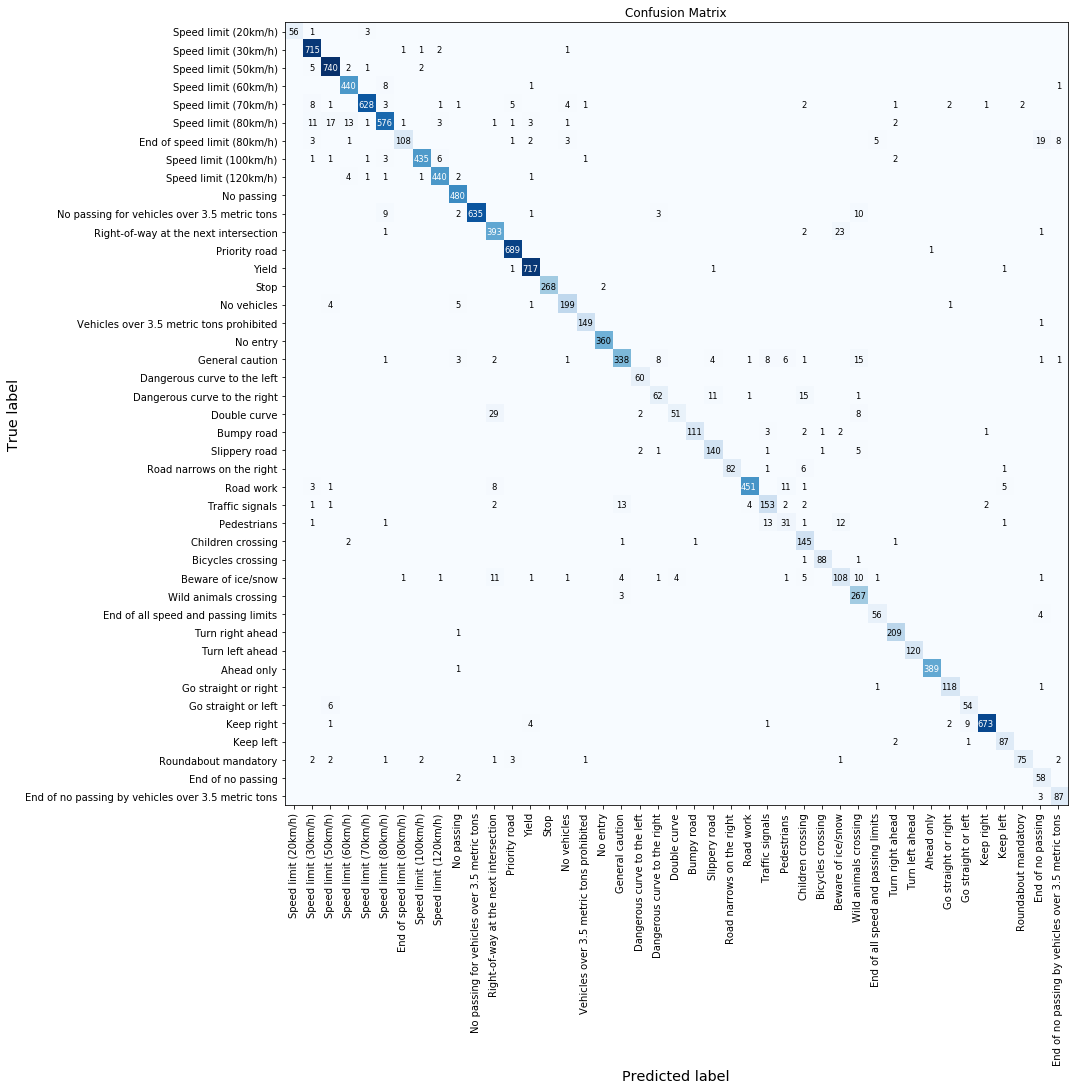

In [79]:
y_predictions = tf.argmax(logits, 1)
y_truth = tf.convert_to_tensor(y_test_process)
confusion_operation = tf.contrib.metrics.confusion_matrix(y_truth, y_predictions)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, SAVE_FILE)
    confusion = sess.run(confusion_operation, feed_dict={X_vals: X_test_process, keep_prob: 1.})
    plot_confusion_matrix(confusion)

---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [19]:
sign_classes = np.array([7, 9, 11, 17, 25, 31, 40])
n_signs = len(sign_classes)
sign_data = np.empty((n_signs,32,32,3), dtype=np.uint8)
sign_path = "./signs/{}.jpg"

for i, label in enumerate(sign_classes):
    sign_data[i] = cv2.cvtColor(cv2.imread(sign_path.format(label), cv2.IMREAD_COLOR),
                                cv2.COLOR_BGR2RGB)
sign_data_process = preprocess(sign_data)

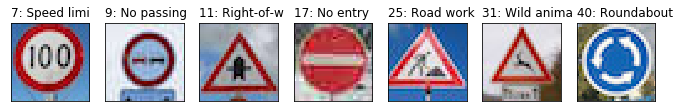

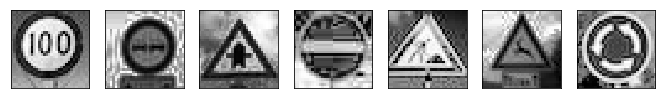

In [20]:
visualize_class(sign_data, sign_classes, maxtitlelen=10, figsize=(20, 2))
visualize_class(sign_data_process.reshape(sign_data_process.shape[:3]), figsize=(20, 2), cmap="gray")

### Predict the Sign Type for Each Image

In [21]:
n_preds = 5
prediction_operation = tf.nn.top_k(tf.nn.softmax(logits), n_preds)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, SAVE_FILE)
    probs, pred_classes = sess.run(prediction_operation, feed_dict={X_vals: sign_data_process, keep_prob: 1.})

In [22]:
def prediction_confidence(img, likelihoods, predictions):
    labels = ["{:.4f}% : {}".format(likelihoods[i]*100, class_labels[str(c)])
              for i, c in enumerate(predictions)]
    y_pos = np.arange(len(labels))

    plt.figure(figsize=(4,2))
    plt.subplot(121, xticks=[], yticks=[])
    plt.imshow(img)
    plt.subplot(122)
    plt.barh(y_pos, likelihoods)
    plt.yticks(y_pos, labels, position=(1.2,1), ha="left", weight="semibold")
    plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

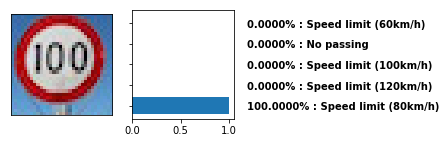

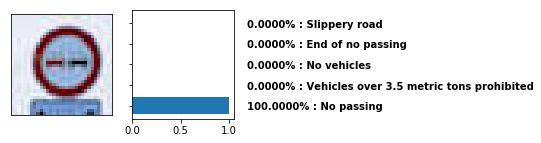

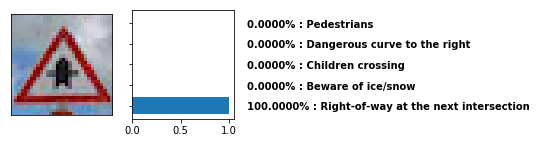

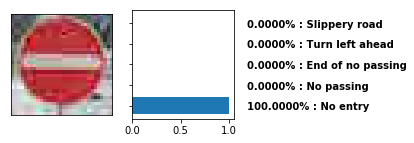

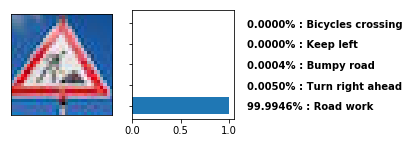

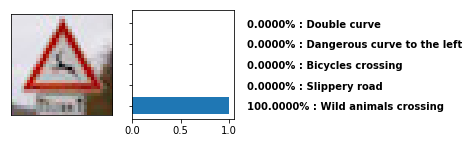

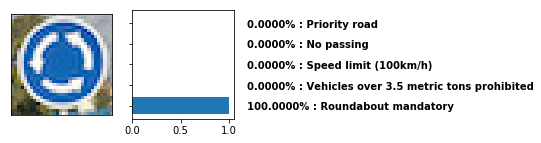

In [23]:
for idx in range(n_signs):
    prediction_confidence(sign_data[idx], probs[idx], pred_classes[idx])

### Analyze Performance

In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tf.train.Saver().restore(sess, SAVE_FILE)
    new_img_accuracy = evaluate(sign_data_process, sign_classes)
    print("New Image Accuracy = {:.3f}".format(new_img_accuracy))

New Image Accuracy = 0.857


---

## Step 4: Visualize the Neural Network's State with Test Images

In [25]:
def outputFeatureMap(session, image_input, activation, cols=8, rows=6, figsize=(1,1), interpolation="nearest", plt_num=0):
    """
    image_input:
        the test image being fed into the network to produce the feature maps
    tf_activation:
        should be a tf variable name used during your training procedure that
        represents the calculated state of a specific weight layer
    """
    n_featuremaps = activation.shape[-1]
    assert rows*cols == n_featuremaps, "expected {}*{} to equal {}".format(rows, cols, n_featuremaps)
    fig = plt.figure(plt_num+1, figsize=figsize)
    for fm in range(n_featuremaps):
        plt.subplot(rows, cols, fm+1, xticks=[], yticks=[])
        plt.imshow(activation[:,:,:,fm].squeeze(), interpolation=interpolation, cmap="gray")

Tensor("conv1/weights/read:0", shape=(5, 5, 1, 32), dtype=float32)


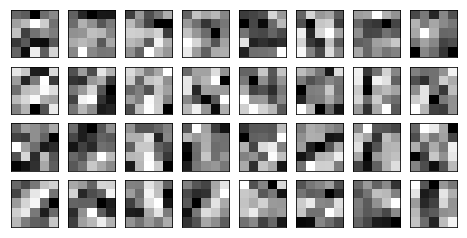

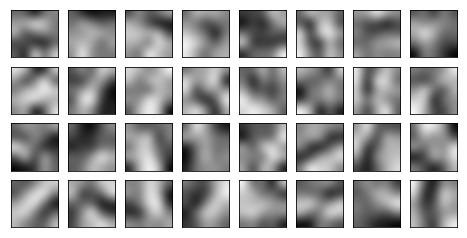

In [28]:
conv1_weights,_ = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="conv1")[:2]
sign_img = sign_data_process[0]

print(conv1_weights)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, SAVE_FILE)
    conv1 = sess.run(conv1_weights, feed_dict={X_vals: [sign_img]})
    outputFeatureMap(sess, sign_img, conv1, cols=8, rows=4, figsize=(8,4), plt_num=0)
    outputFeatureMap(sess, sign_img, conv1, cols=8, rows=4, figsize=(8,4), interpolation="bicubic", plt_num=1)